In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# Wczytaj dane z pliku labels.csv
labels = pd.read_csv("labels.csv", delimiter="\t")

# Dodaj ścieżkę do plików
image_dir = "Images"
labels["File Path"] = labels["File Name"].apply(lambda x: os.path.join(image_dir, x))

# Przygotowanie danych wejściowych i etykiet
X = labels["File Path"].values
y = labels[["Apple", "Banana", "Orange"]].values

# Podziel dane na zbiory treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Funkcja do wczytywania i przetwarzania obrazów
def preprocess_image(file_path, img_size=(224, 224)):
    image = tf.keras.preprocessing.image.load_img(file_path, target_size=img_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0  # Normalizacja do zakresu [0, 1]
    return image

# Wczytaj i przetwórz dane
X_train_processed = np.array([preprocess_image(fp) for fp in X_train])
X_val_processed = np.array([preprocess_image(fp) for fp in X_val])

In [ ]:
# Definicja modelu CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu',kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu',kernel_regularizer=l2(0.0001)),
    MaxPooling2D((2, 2)),
    

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dense(3, activation='sigmoid') 
])

# Określenie wag klas
class_weights = {
    0: 0.7,  # Apple
    1: 1.3,  # Banana
    2: 1.2   # Orange
}

# Kompilacja modelu
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    filepath="top_model.keras",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_weights_only=False
)



c:\Users\matri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Trenowanie modelu
history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_val_processed, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[reduce_lr, early_stopping, checkpoint],
    class_weight=class_weights
)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2975 - loss: 0.8356 - val_accuracy: 0.2400 - val_loss: 0.8193 - learning_rate: 5.0000e-04
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 961ms/step - accuracy: 0.2513 - loss: 0.7895 - val_accuracy: 0.2400 - val_loss: 0.7863 - learning_rate: 5.0000e-04
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 969ms/step - accuracy: 0.3650 - loss: 0.7186 - val_accuracy: 0.3600 - val_loss: 0.7410 - learning_rate: 5.0000e-04
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4856 - loss: 0.6406 - val_accuracy: 0.4000 - val_loss: 0.6969 - learning_rate: 5.0000e-04
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 913ms/step - accuracy: 0.4897 - loss: 0.6044 - val_accuracy: 0.5600 - val_loss: 0.5861 - learning_rate: 5.0000e-04
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 819ms/step - accuracy: 0.7003 - loss: 0.5204 - val_accuracy: 0.5600 - val_loss: 0.5930 - learning_rate: 5.0000e-04
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 881ms/step - accuracy: 0.6841 - loss: 0.43

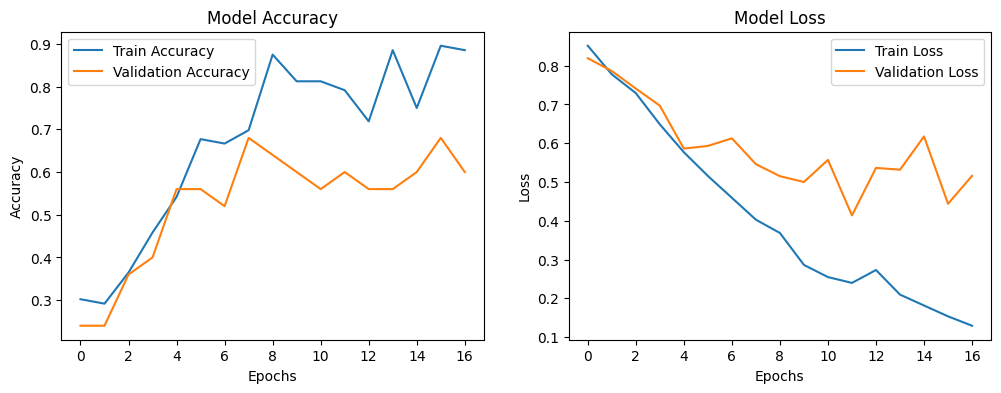

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Classification Report on Validation Set (Best Model):
              precision    recall  f1-score   support

       Apple       1.00      0.93      0.97        15
      Banana       0.87      0.93      0.90        14
      Orange       0.92      0.92      0.92        13

   micro avg       0.93      0.93      0.93        42
   macro avg       0.93      0.93      0.93        42
weighted avg       0.93      0.93      0.93        42
 samples avg       0.95      0.95      0.94        42



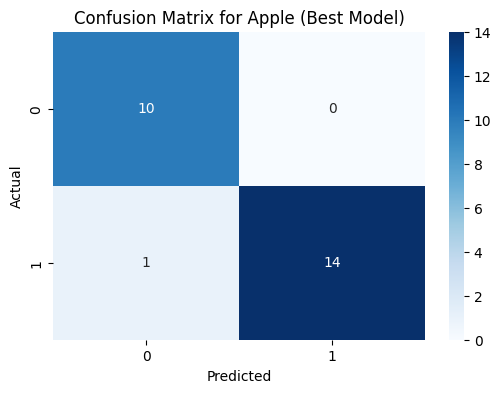

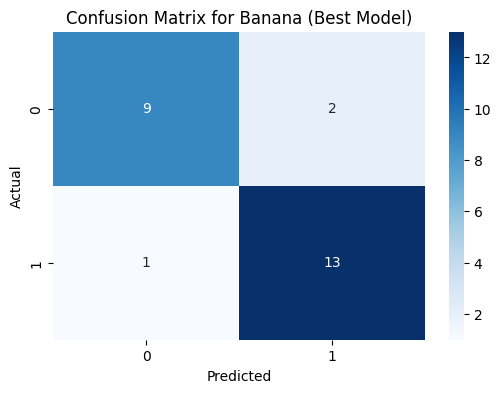

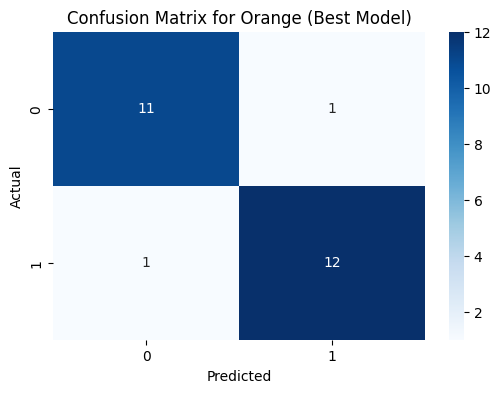

In [8]:
# Wizualizacja wyników
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Predykcje na zbiorze walidacyjnym
# Wczytanie najlepszego modelu
best_model = tf.keras.models.load_model("top_model.keras")

# Ponowna ewaluacja na zbiorze walidacyjnym
y_pred = best_model.predict(X_val_processed)
y_pred_binary = (y_pred > 0.5).astype(int)

# Wyświetlenie raportu klasyfikacji dla najlepszego modelu
print("Classification Report on Validation Set (Best Model):")
print(classification_report(y_val, y_pred_binary, target_names=["Apple", "Banana", "Orange"]))

# Generowanie macierzy konfuzji dla każdej klasy (najlepszy model)
for i, class_name in enumerate(["Apple", "Banana", "Orange"]):
    cm = confusion_matrix(y_val[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.title(f'Confusion Matrix for {class_name} (Best Model)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()